In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor 
import matplotlib.pyplot as plt
import os.path
from os import path
from sklearn.neural_network import MLPRegressor

In [2]:
def LoadRawVariables():
    c2pt = []
    ts   = []
    taus = []
    xs   = []
    ys   = []
    zs   = []
    c3pt_S = []
    c3pt_V = []
    c3pt_A = []
    c2pt_OTHER = []
    
    
    for tau in range(0, 49, 8):
        for x in range(0, 25, 8):
            for y in range(0, 25, 8):
                for z in range(0, 25, 8):
                    for sample in range(748, 1421, 16):
                        fname = "../Data/T" + str(tau) + "/x" + str(x) + "y" + str(y) + "z" + str(z) + "/nuc3pt.dat." + str(sample)
                        if path.exists(fname):
                            with open(fname) as fp:
                                for i, line in enumerate(fp):
                                    if i >= 7 and i <= 70:           # The start of Gauss -> Point 2pt correlation functions
                                        c2pt_OTHER.append([float(x) for x in line.rstrip().split()[1:3]])
                                    if i >= 5182 and i <= 5245:      # The start of Gauss -> Gauss 2pt correlation functions
                                        c2pt.append([float(x) for x in line.rstrip().split()[1:3]])
                                        ts.append(i - 5182)
                                        taus.append(tau)
                                        xs.append(x)
                                        ys.append(y)
                                        zs.append(z)
                                    elif i >= 10154 and i <= 10217:
                                        c3pt_S.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 10229 and i <= 10292:
                                        c3pt_V.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i >= 19979 and i <= 20042:
                                        c3pt_A.append([float(x) for x in line.rstrip().split()[1:5]])
                                    elif i > 20042:
                                        break
    
    return ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER

ts, taus, xs, ys, zs, c2pt, c3pt_S, c3pt_V, c3pt_A, c2pt_OTHER = LoadRawVariables()

c2pt_factor_raw = sum(np.array(c2pt)) / len(c2pt)
N_factor = np.sqrt(c2pt_factor_raw[0] ** 2 + c2pt_factor_raw[1] ** 2)

for i in range(len(c2pt)):
    for j in range(2):
        c2pt[i][j] /= N_factor
        c2pt_OTHER[i][j] /= N_factor
    for j in range(4):
        c3pt_S[i][j] /= N_factor
        c3pt_V[i][j] /= N_factor
        c3pt_A[i][j] /= N_factor

## Prediction of c3pt at each time slice

In [3]:
## Features is a 64 x <# Data> x <Size Data> 3D array for all 64 sets of lists of features
## Labels is a 64 x <# Data> 2D array for all 64 sets of lists of labels

features_unshifted = np.array([[taus[i]] + [c2pt[i + j][0] for j in range(64)] + [c2pt[i + j][1] for j in range(64)] for i in range(0, len(ts), 64)])
features = []
for i in range(64):
    features.append([])
    for f in features_unshifted:
        shift = int(f[0])
        features[i].append(np.roll(f[1:], -shift))

features = np.array(features)

labels_S_up = np.array([[c3pt_S[i+j][0] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_up = np.array([[c3pt_A[i+j][0] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_up = np.array([[c3pt_V[i+j][0] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

labels_S_down = np.array([[c3pt_S[i+j][2] for i in range(0, len(c3pt_S), 64)] for j in range(64)])
labels_A_down = np.array([[c3pt_A[i+j][2] for i in range(0, len(c3pt_A), 64)] for j in range(64)])
labels_V_down = np.array([[c3pt_V[i+j][2] for i in range(0, len(c3pt_V), 64)] for j in range(64)])

## Scalar charge

In [4]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_S_up[:, :labelEnd], labels_S_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_S_up[:, labelEnd:BCEnd], labels_S_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_S_up[:, BCEnd:], labels_S_down[:, BCEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.21597053076234352


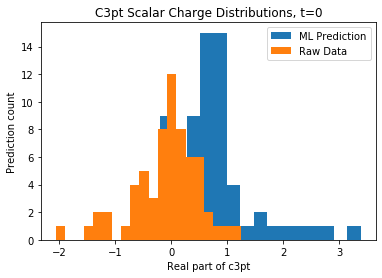

Prediction quality @ t=1: 0.2563996746175591


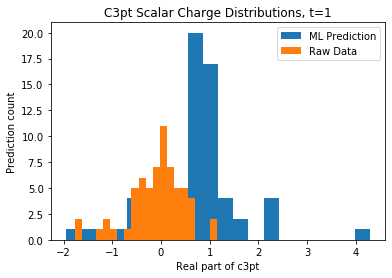

Prediction quality @ t=2: 0.3100021105723186


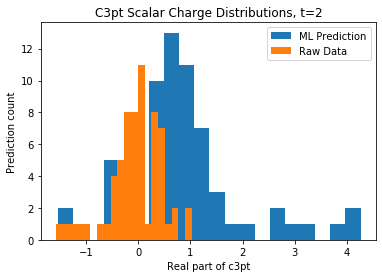

Prediction quality @ t=3: 0.41908147181332045


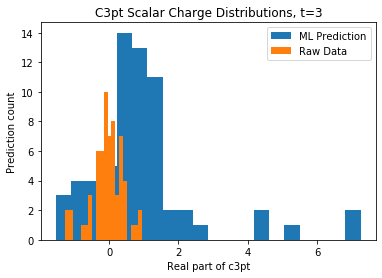

Prediction quality @ t=4: 0.37470290073653617


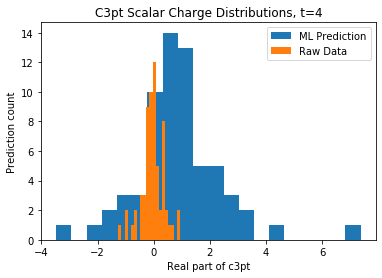

Prediction quality @ t=5: 0.4639903017738537


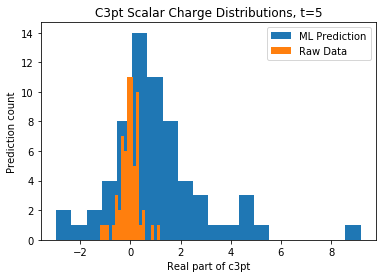

Prediction quality @ t=6: 0.5369320382194699


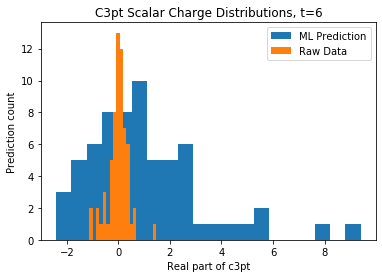

Prediction quality @ t=7: 0.6008307699540993


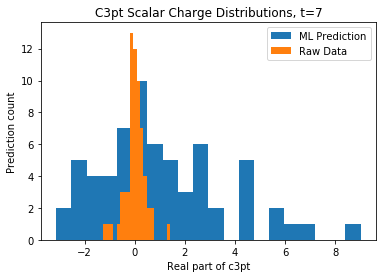

Prediction quality @ t=8: 0.7049433419790897


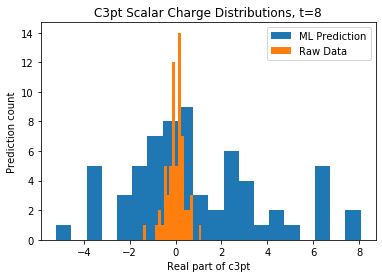

Prediction quality @ t=9: 21.06503599851902


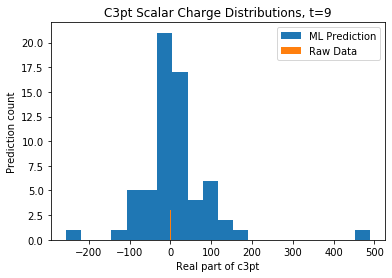

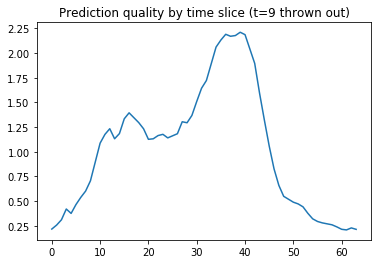

In [5]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        DM_samples.append(testLabel_up)
        ML_samples.append(pred_up[0])

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(X_train[t]))

    plt.hist(ML_samples, bins=20)
    plt.hist(DM_samples, bins=20)
    plt.legend(["ML Prediction", "Raw Data"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Scalar Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    if t % 8 == 1 and t != 1:
        quals.append(0)
        continue
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(X_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()

In [14]:
labelFrac = 0.5
BCFrac = 0.1

labelEnd = int(len(labels_S_up[0]) * labelFrac)
BCEnd    = int(len(labels_S_up[0]) * (BCFrac + labelFrac))

X_train, Y_train_up, Y_train_down = features[:, :labelEnd], labels_V_up[:, :labelEnd], labels_V_down[:, :labelEnd]
X_bc, Y_bc_up, Y_bc_down = features[:, labelEnd:BCEnd], labels_V_up[:, labelEnd:BCEnd], labels_V_down[:, labelEnd:BCEnd]
X_test, Y_test_up, Y_test_down = features[:, BCEnd:], labels_V_up[:, BCEnd:], labels_V_down[:, BCEnd:]

gbr_up = list(range(64))
gbr_down = list(range(64))
biasCrxn_up = list(range(64))
biasCrxn_down = list(range(64))
for i in range(64):
    gbr_up[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_up[i].fit(X_train[i], Y_train_up[i])
    
    gbr_down[i] = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, max_depth=3)
    gbr_down[i].fit(X_train[i], Y_train_down[i])

    y_bc_pred_up = gbr_up[i].predict(X_bc[i])
    y_bc_pred_down = gbr_down[i].predict(X_bc[i])

    biasCrxn_up[i] = np.average(Y_bc_up - y_bc_pred_up)
    biasCrxn_down[i] = np.average(Y_bc_down - y_bc_pred_down)

Prediction quality @ t=0: 0.00793770105187173


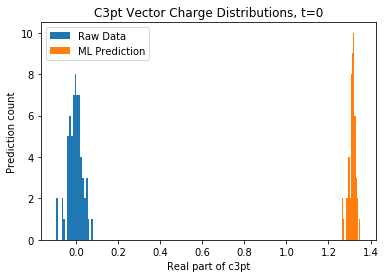

Prediction quality @ t=1: 0.010580852435413443


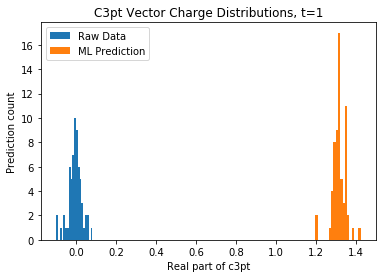

Prediction quality @ t=2: 0.01157362968160317


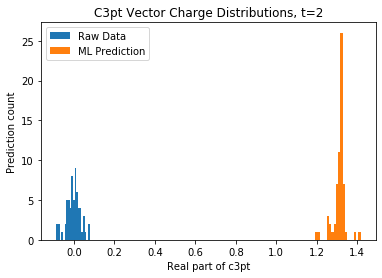

Prediction quality @ t=3: 0.011679785660065766


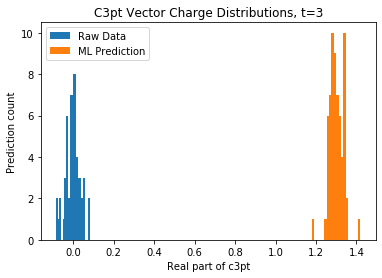

Prediction quality @ t=4: 0.009456914979162838


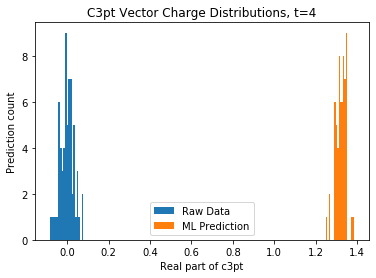

Prediction quality @ t=5: 0.015259880650556576


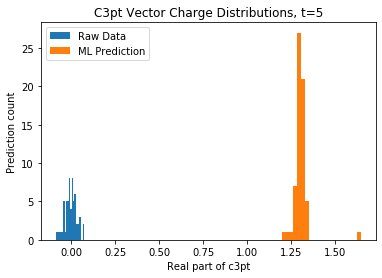

Prediction quality @ t=6: 0.008923051607773496


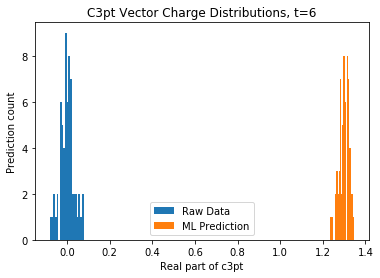

Prediction quality @ t=7: 0.016716899079425997


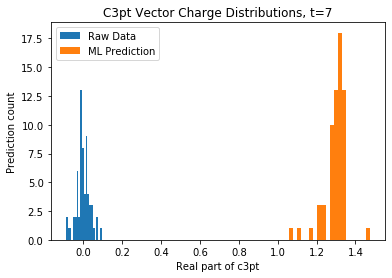

Prediction quality @ t=8: 0.09161559133278406


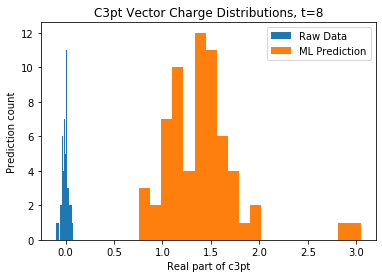

Prediction quality @ t=9: 2.217150621014748


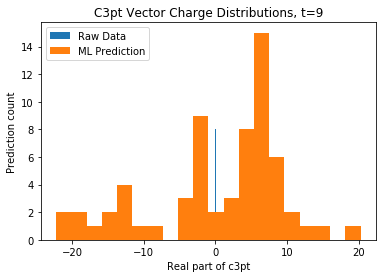

Prediction quality @ t=10: 0.15209077047133476


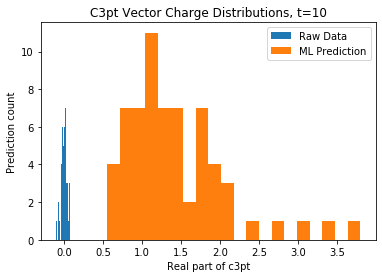

Prediction quality @ t=11: 0.17435434507884592


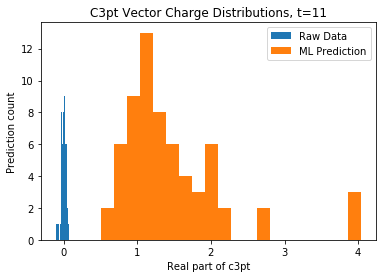

Prediction quality @ t=12: 0.16297110931506512


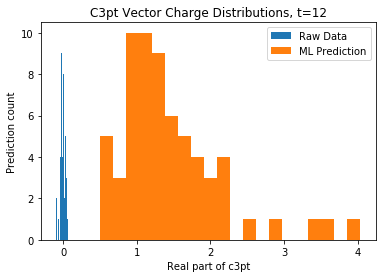

Prediction quality @ t=13: 0.14899325776852868


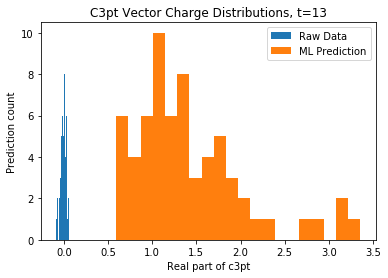

Prediction quality @ t=14: 0.17528329225534905


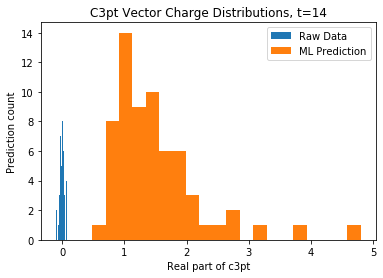

Prediction quality @ t=15: 0.15465395732068085


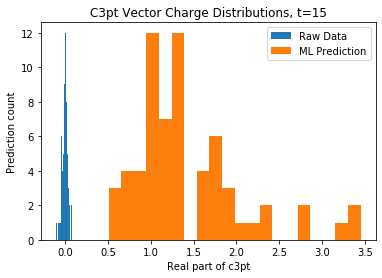

Prediction quality @ t=16: 0.22943832086684182


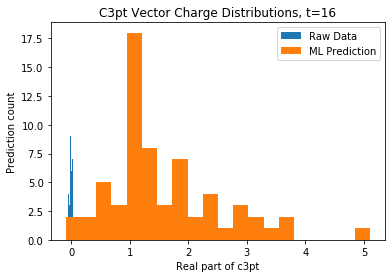

Prediction quality @ t=17: 15.684670747441379


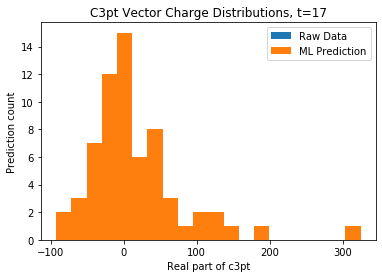

Prediction quality @ t=18: 0.14828969771788503


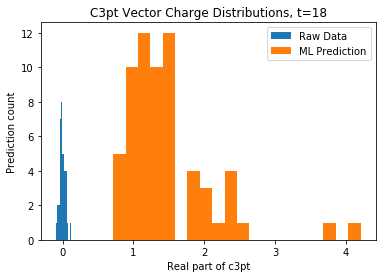

Prediction quality @ t=19: 0.15247195723446094


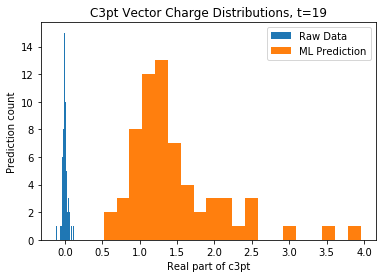

Prediction quality @ t=20: 0.14273459843118042


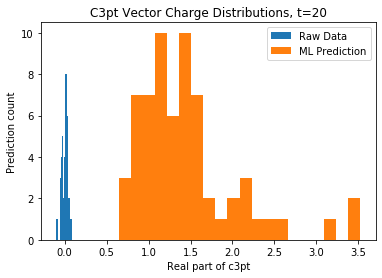

Prediction quality @ t=21: 0.15372459610446979


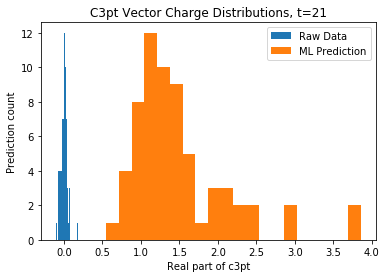

Prediction quality @ t=22: 0.14207375527013238


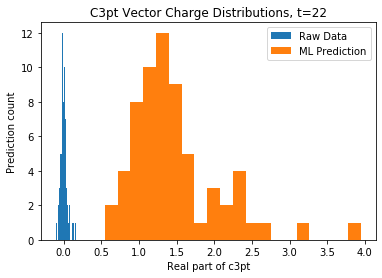

Prediction quality @ t=23: 0.14239821513134673


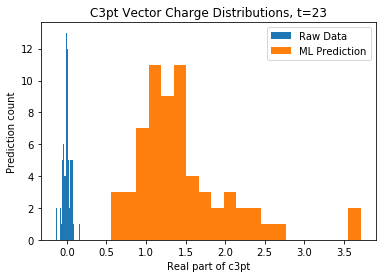

Prediction quality @ t=24: 0.16855666984870896


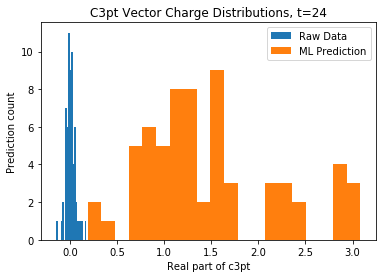

Prediction quality @ t=25: 17.94513034520389


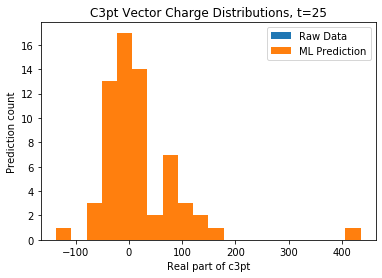

Prediction quality @ t=26: 0.03960748089516572


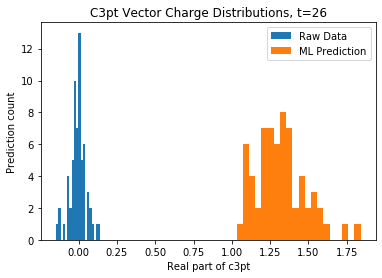

Prediction quality @ t=27: 0.07076799307997664


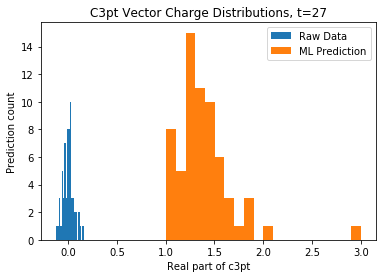

Prediction quality @ t=28: 0.06203222748393681


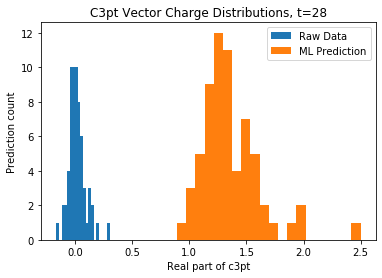

Prediction quality @ t=29: 0.08256516081650248


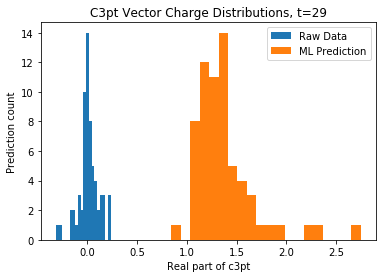

Prediction quality @ t=30: 0.08770026007003533


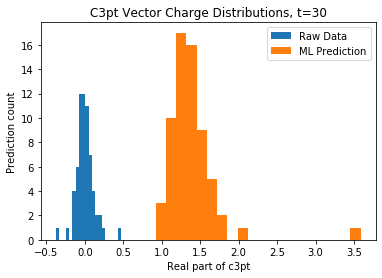

Prediction quality @ t=31: 0.06750950197892655


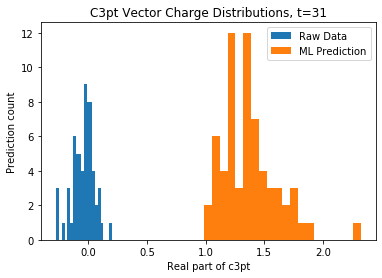

Prediction quality @ t=32: 0.15088932894807985


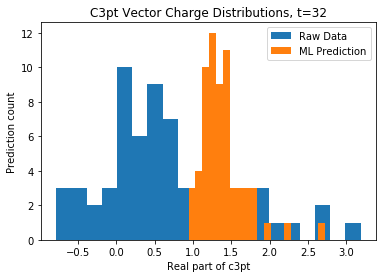

Prediction quality @ t=33: 6.873321292797711


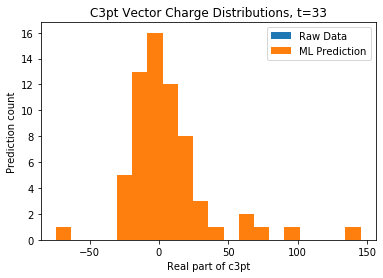

Prediction quality @ t=34: 0.3772461506031395


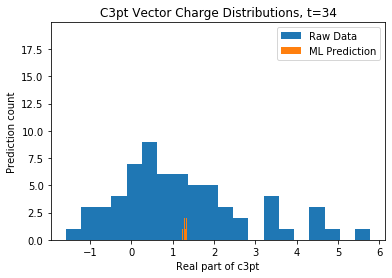

Prediction quality @ t=35: 0.37005558436600494


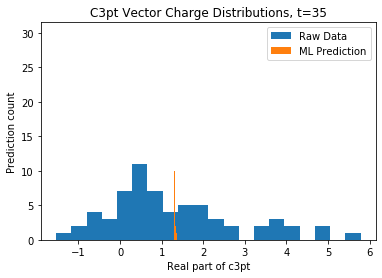

Prediction quality @ t=36: 0.37235481610994803


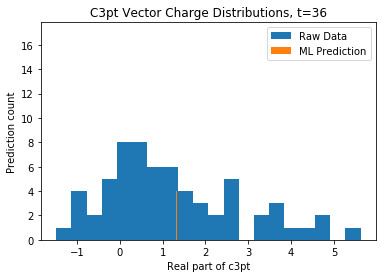

Prediction quality @ t=37: 0.3719149810806476


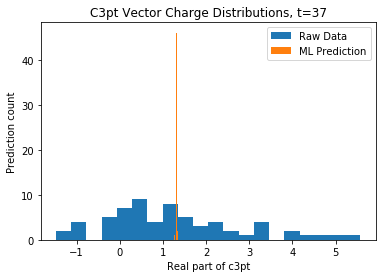

Prediction quality @ t=38: 0.3742705142824885


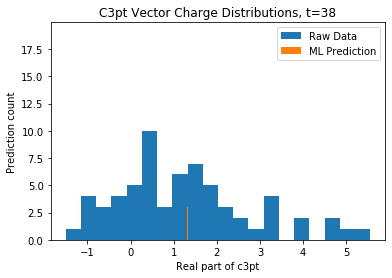

Prediction quality @ t=39: 0.3783586714114601


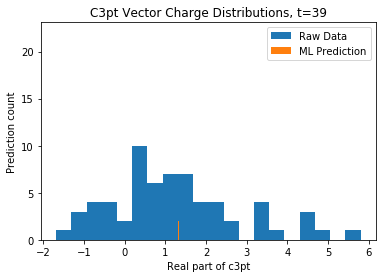

Prediction quality @ t=40: 0.3941038639165079


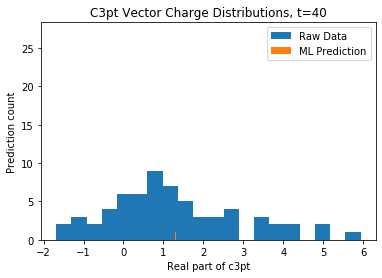

Prediction quality @ t=41: 43.14528432680102


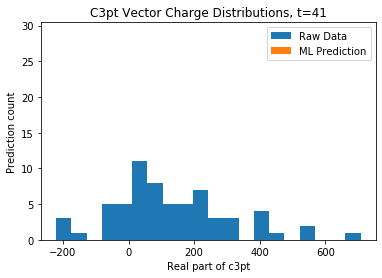

Prediction quality @ t=42: 0.023679056215656313


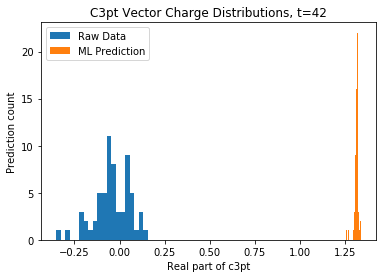

Prediction quality @ t=43: 0.022265299174490015


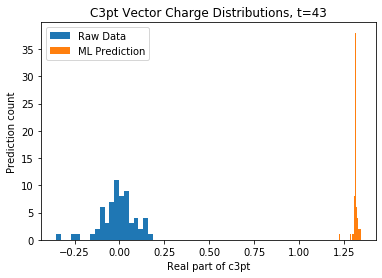

Prediction quality @ t=44: 0.022563246299305898


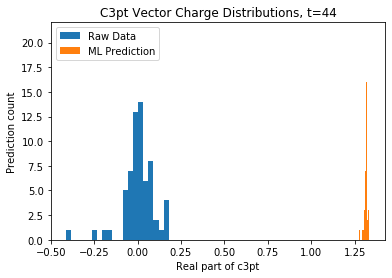

Prediction quality @ t=45: 0.016828218688684355


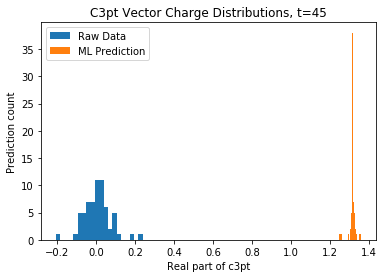

Prediction quality @ t=46: 0.015398652783161167


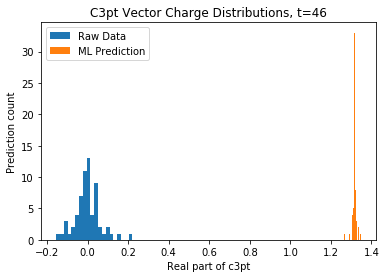

Prediction quality @ t=47: 0.013732641771818715


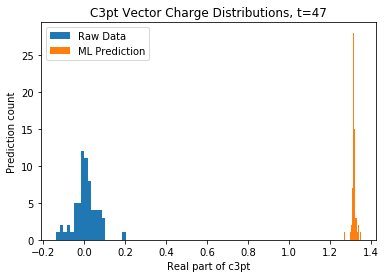

Prediction quality @ t=48: 0.013412228467670595


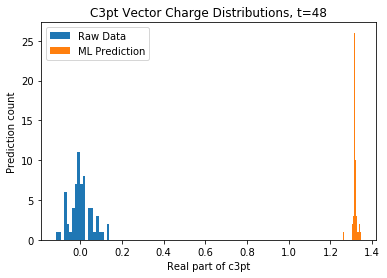

Prediction quality @ t=49: 0.011909751497433754


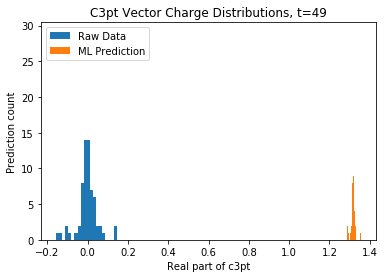

Prediction quality @ t=50: 0.010046493025036494


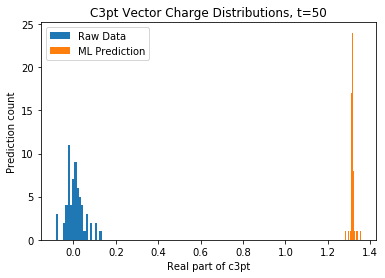

Prediction quality @ t=51: 0.010460783291984035


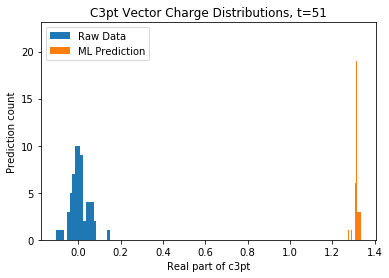

Prediction quality @ t=52: 0.009920238920371152


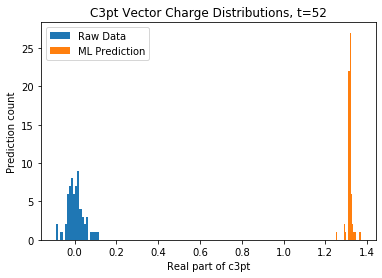

Prediction quality @ t=53: 0.011066083560999081


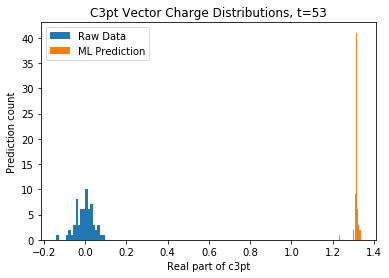

Prediction quality @ t=54: 0.008543998693750974


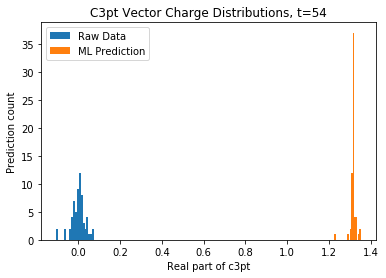

Prediction quality @ t=55: 0.008537714861522378


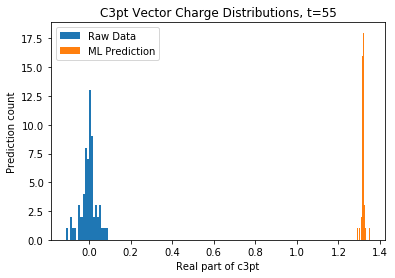

Prediction quality @ t=56: 0.008367183037063932


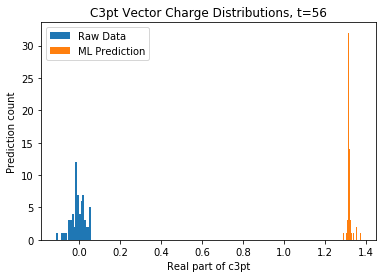

Prediction quality @ t=57: 0.008250005492277859


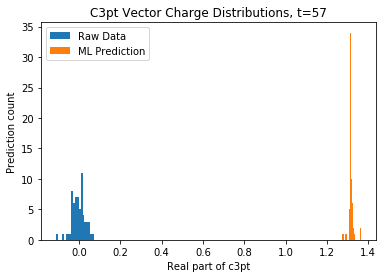

Prediction quality @ t=58: 0.008515045837566909


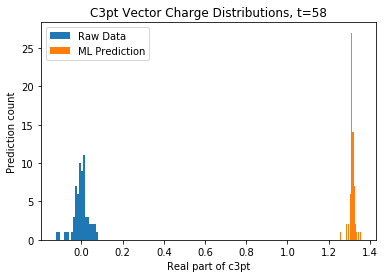

Prediction quality @ t=59: 0.008607849305594882


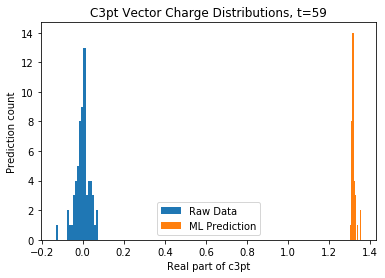

Prediction quality @ t=60: 0.00897559028540085


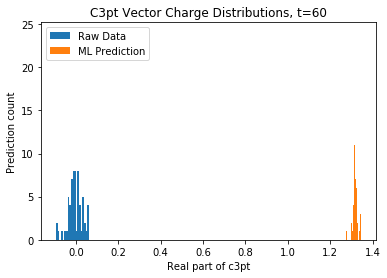

Prediction quality @ t=61: 0.007189775607267701


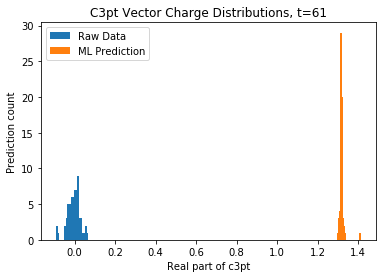

Prediction quality @ t=62: 0.008749070779100525


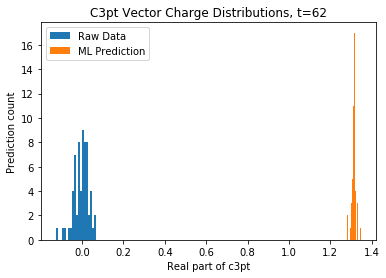

Prediction quality @ t=63: 0.007466029924420457


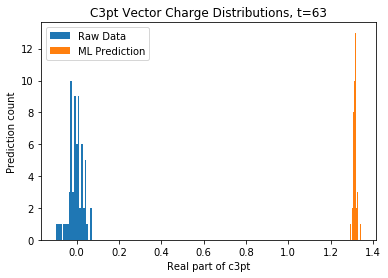

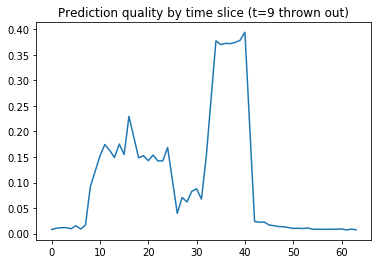

In [16]:
for t in range(64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    print("Prediction quality @ t=" + str(t) + ":", np.std(errors) / np.std(X_train[t]))

    plt.hist(DM_samples, bins=20)
    plt.hist(ML_samples, bins=20)
    plt.legend(["Raw Data", "ML Prediction"])
    plt.xlabel("Real part of c3pt")
    plt.ylabel("Prediction count")
    plt.title("C3pt Vector Charge Distributions, t=" + str(t))
    plt.show()

quals = []
for t in range(0, 64):
    errors = []
    ML_samples = []
    DM_samples = []
    for i in range(len(X_test)):
        testImg = X_test[t][i]
        testLabel_up = Y_test_up[t][i]
        pred_up = gbr_up[t].predict([testImg]) + biasCrxn_up[t]
        errors.append(pred_up - testLabel_up)
        ML_samples.append(pred_up[0])
        DM_samples.append(testLabel_up)

    quals.append(np.std(errors) / np.std(X_train[t]))
    
for i in range(9, 64, 8):
    quals[i] = (quals[i-1] + quals[i + 1]) / 2

plt.plot(list(range(64)), quals)
plt.title("Prediction quality by time slice (t=9 thrown out)")
plt.show()